In [170]:
from Capstone_Group02_Utility import Logisticsmodel, DTClassifier,RFClassifier,GBClassifier,NNClassifier,KNNClassifier,model_evaluation

In [171]:
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as pl
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

### CEREBRAL STROKE PREDICTION MODEL

# Data Loading

In [172]:


dataset=pd.read_csv('https://dataverse.harvard.edu/api/access/datafile/4402679', delimiter='\t')
dataset.head(3)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0


In [107]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 43400 non-null  int64  
 1   gender             43400 non-null  object 
 2   age                43400 non-null  float64
 3   hypertension       43400 non-null  int64  
 4   heart_disease      43400 non-null  int64  
 5   ever_married       43400 non-null  object 
 6   work_type          43400 non-null  object 
 7   Residence_type     43400 non-null  object 
 8   avg_glucose_level  43400 non-null  float64
 9   bmi                41938 non-null  float64
 10  smoking_status     30108 non-null  object 
 11  stroke             43400 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 4.0+ MB


# Finding missing values
- BMI and Smoking status are missing values

In [108]:

dataset.isnull().sum()

id                       0
gender                   0
age                      0
hypertension             0
heart_disease            0
ever_married             0
work_type                0
Residence_type           0
avg_glucose_level        0
bmi                   1462
smoking_status       13292
stroke                   0
dtype: int64

### Replacing missing values of bmi with its mean

In [109]:

avgbmi=np.round(dataset['bmi'].mean())
dataset['bmi'].fillna(avgbmi, inplace= True)
dataset['smoking_status'].fillna('not known', inplace= True)

### Dropping off column and values
- dropping id column 
- dropping off gender that is categorized as 'other'

In [110]:

dataset = dataset[dataset['gender'] != 'Other']
dataset.drop('id', axis=1, inplace=True)

# EXPLORATORY DATA ANALYSIS

### Distribution of Target Variable
- Distribution shows that the dataset is imbalanced and it may make the model to produce biased result

Text(0.5, 1.0, 'Imbalanced Dataset')

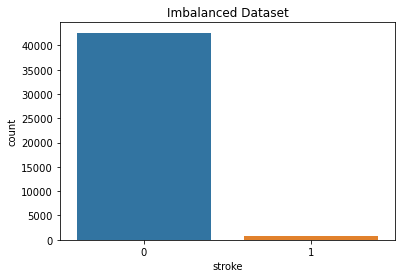

In [111]:

sns.countplot(x='stroke', data=dataset).set_title('Imbalanced Dataset')

### Distribution of Numerical variables

- Stroke increase with age
- Lower range of BMI(20-30) increases the risk of stroke
- Higher range of glucose level(160-240) increases the risk of stroke


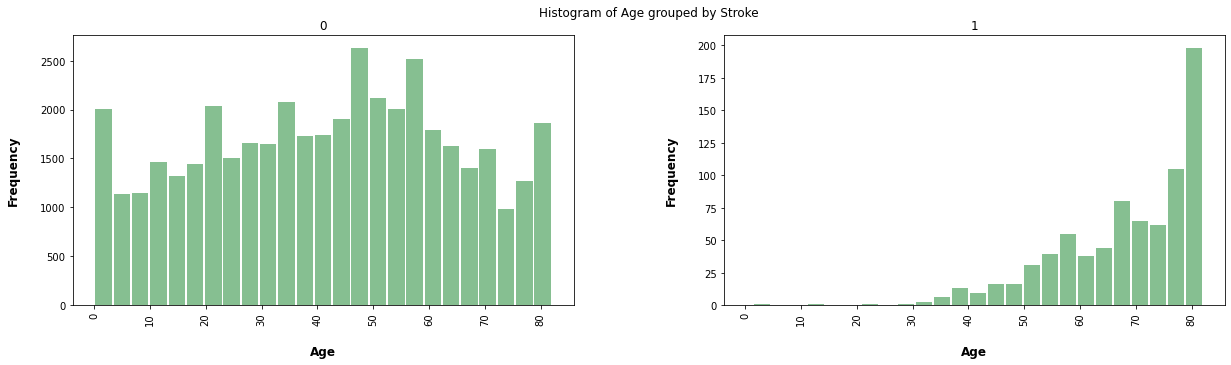

In [112]:
#Distribution of Age

plot1=dataset.hist(column='age', by='stroke',bins=25,grid=False, figsize=(20,5), layout=(1,2), sharex=True, color='#86bf91', zorder=2, rwidth=0.9)
pl.suptitle('Histogram of Age grouped by Stroke')
for i,x in enumerate(plot1):
      x.set_xlabel("Age", labelpad=20, weight='bold', size=12)
      x.set_ylabel("Frequency", labelpad=20, weight='bold', size=12)

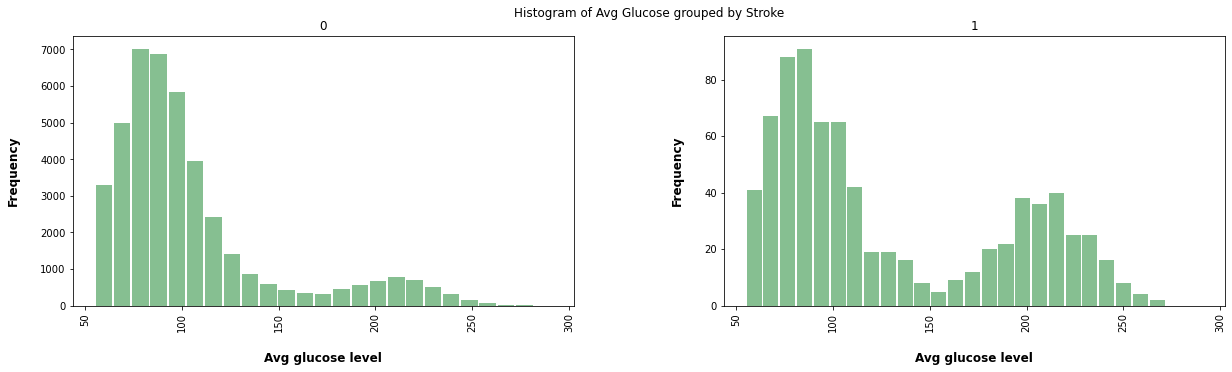

In [113]:
#Distribution of Average Glucose level

plot2= dataset.hist(column='avg_glucose_level', by='stroke',bins=25, grid=False, figsize=(20,5), layout=(1,2), sharex=True, color='#86bf91', zorder=2, rwidth=0.9)
pl.suptitle('Histogram of Avg Glucose grouped by Stroke')
for i,x in enumerate(plot2):
    x.set_xlabel("Avg glucose level", labelpad=20, weight='bold', size=12)
    x.set_ylabel("Frequency", labelpad=20, weight='bold', size=12)

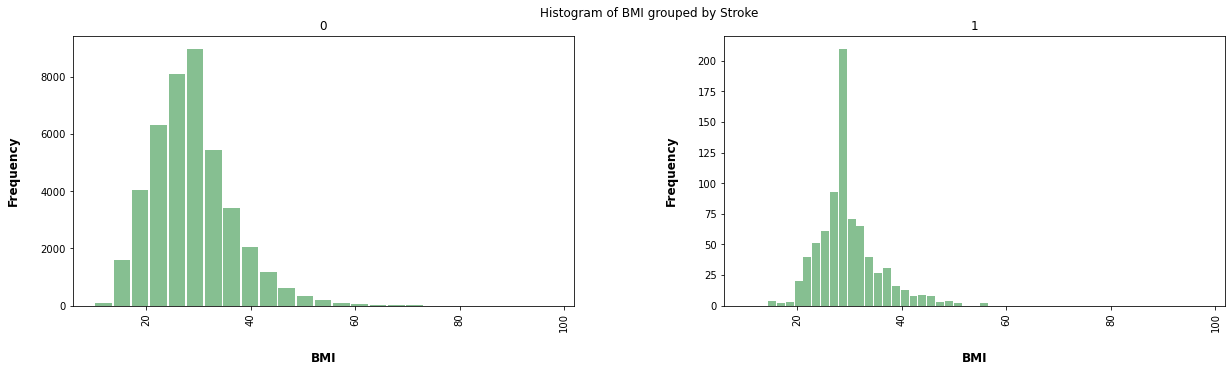

In [114]:
#Distribution of BMI

plot3= dataset.hist(column='bmi', by='stroke',bins=25, grid=False, figsize=(20,5), layout=(1,2), sharex=True, color='#86bf91', zorder=2, rwidth=0.9)
pl.suptitle('Histogram of BMI grouped by Stroke')
for i,x in enumerate(plot3):
    x.set_xlabel("BMI", labelpad=20, weight='bold', size=12)
    x.set_ylabel("Frequency", labelpad=20, weight='bold', size=12)


### Distribution of Categorical variables

- Gender and Residency type has no effect on stroke
- Married ones are more prone to stroke
- Working in private company exposes more to stroke
- Being a smoker or former smoker increases the risk of getting stroke. Surprisingly, non-smoker also affected more with stroke.
- About 25-30% of stroke patients had hypertension and heart problems


[Text(0.5, 1.0, 'Residence Type vs stroke'), Text(0.5, 0, 'Residence Type')]

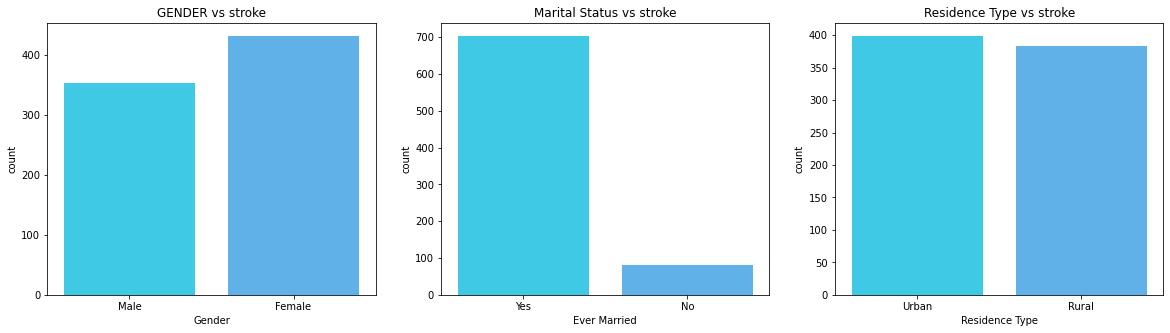

In [115]:
# Distribution of Gender, Marital Status and Residency Type
strokepositive=dataset[dataset['stroke'] == 1]
fig,ax=plt.subplots(nrows=1,ncols=3,figsize=(20,5))
CPalette1=sns.color_palette("cool")
sns.countplot(x='gender', data=strokepositive,palette=CPalette1,ax=ax[0]).set(title='GENDER vs stroke', xlabel='Gender')
sns.countplot(x='ever_married', data=strokepositive,palette=CPalette1,ax=ax[1]).set(title='Marital Status vs stroke', xlabel='Ever Married')
sns.countplot(x='Residence_type', data=strokepositive,palette=CPalette1, ax=ax[2]).set(title='Residence Type vs stroke', xlabel='Residence Type')


[Text(0.5, 1.0, 'Heart Disease vs Stroke'), Text(0.5, 0, 'Heart Disease')]

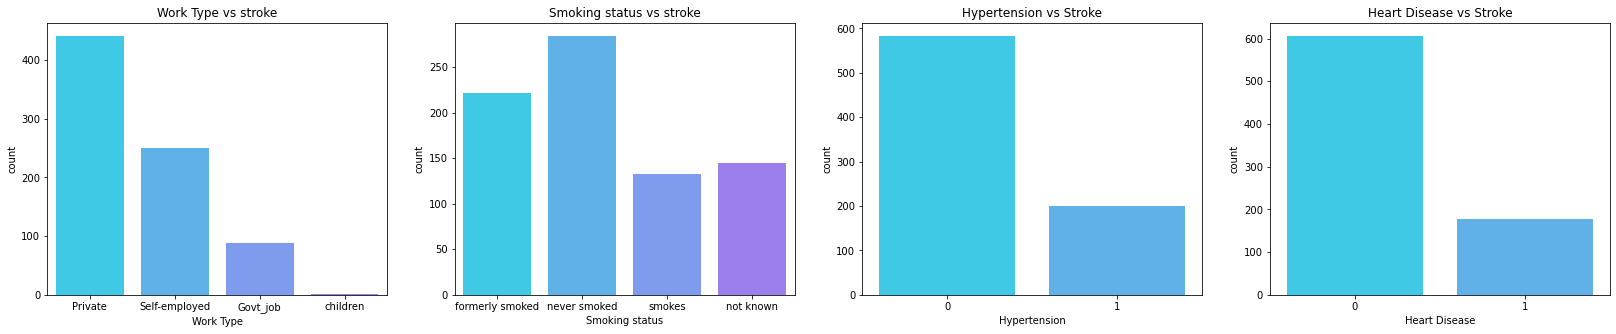

In [116]:
# Distribution of Work type, Smoking Status, hypertension and heart disease

fig,ax=plt.subplots(nrows=1,ncols=4,figsize=(28,5))
sns.countplot(x='work_type', data=strokepositive,palette=CPalette1, ax=ax[0]).set(title='Work Type vs stroke', xlabel='Work Type')
sns.countplot(x='smoking_status', data=strokepositive,palette=CPalette1, ax=ax[1]).set(title='Smoking status vs stroke', xlabel='Smoking status')
sns.countplot(x='hypertension', data=strokepositive,palette=CPalette1, ax=ax[2]).set(title='Hypertension vs Stroke', xlabel='Hypertension')
sns.countplot(x='heart_disease', data=strokepositive,palette=CPalette1, ax=ax[3]).set(title='Heart Disease vs Stroke', xlabel='Heart Disease')

### Correlation Map
- Correlation map reveals that stroke is correlated with age, heart disease comparatively than the other variables

<AxesSubplot:>

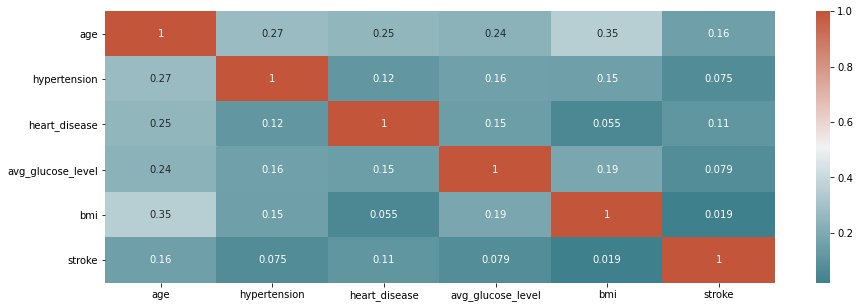

In [117]:
# Correlation Heatmap

plt.figure(figsize=(15,5))
cpalette2=sns.diverging_palette(210, 20, as_cmap=True)
sns.heatmap(dataset.corr(), annot=True,cmap=cpalette2)

# DATA PREPROCESSING

### One Hot Encoding
- One hot encoding is used to transform the categorical variables into numerical so that it can be feed to the model

In [118]:
#One hot encoding of categorical variables

dataset=pd.get_dummies(dataset, columns=['gender','ever_married','work_type','Residence_type','smoking_status'])
dataset.head(3)

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,ever_married_No,ever_married_Yes,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_not known,smoking_status_smokes
0,3.0,0,0,95.12,18.0,0,0,1,1,0,...,0,0,0,1,1,0,0,0,1,0
1,58.0,1,0,87.96,39.2,0,0,1,0,1,...,0,1,0,0,0,1,0,1,0,0
2,8.0,0,0,110.89,17.6,0,1,0,1,0,...,0,1,0,0,0,1,0,0,1,0


### Standardization
- Standard scalar method was used to standardize the variables as age, bmi and avg_glucose level variables were measured in different scale

In [119]:
# Standardization of numerical varaibles

std= StandardScaler()
Scolumns =['age','avg_glucose_level','bmi']
scaled=std.fit_transform(dataset[['age','avg_glucose_level','bmi']])
scaled=pd.DataFrame(scaled, columns=Scolumns)

In [120]:
dataset=dataset.drop(columns=Scolumns, axis=1)

In [121]:
dataset=dataset.merge(scaled, left_index=True, right_index=True)

In [122]:
dataset.isnull().sum()

hypertension                      0
heart_disease                     0
stroke                            0
gender_Female                     0
gender_Male                       0
ever_married_No                   0
ever_married_Yes                  0
work_type_Govt_job                0
work_type_Never_worked            0
work_type_Private                 0
work_type_Self-employed           0
work_type_children                0
Residence_type_Rural              0
Residence_type_Urban              0
smoking_status_formerly smoked    0
smoking_status_never smoked       0
smoking_status_not known          0
smoking_status_smokes             0
age                               0
avg_glucose_level                 0
bmi                               0
dtype: int64

### Training and Test dataset

In [123]:
# Splitting Train and Test data

X=dataset.drop(['stroke'], axis=1)
Y=dataset['stroke']

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

### Data Balancing using SMOTE
- As the original data is inbalanced, the dataset has to be balanced by applying one of the methods such as undersampling, oversampling or bagging. As the dataset is imbalanced with minority class, this minority class has to be oversampled by a method called SMOTE(Synethetic Minority Oversampling Technique).

In [125]:
# Data balancing using SMOTE

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=27)
X_train, y_train = sm.fit_sample(X_train, y_train)

C:\Users\gokul\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'Balanced Dataset after application of SMOTE')

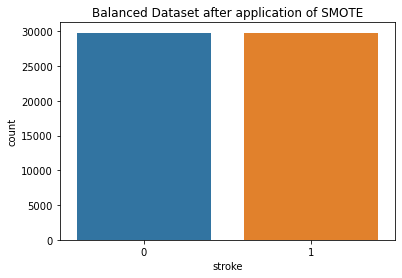

In [126]:
sns.countplot(y_train).set_title("Balanced Dataset after application of SMOTE")

# MODEL DEVELOPMENT
- As the target variable is categorical, Classification models are used to build the prediction model

### Logistic Regression
- It is the simplest regression analysis model to predict the categorical variable
- Logistic regression model achieved an accuracy of 80% which is not bad. 

In [145]:
# Logistic Regression
LR=Logisticsmodel(X_train,y_train,X_test,y_test)
print("Accuracy of Logistic Regression model:{:^0.2f}".format(LR))

Accuracy of Logistic Regression model:0.78


C:\Users\gokul\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



### Decision Tree Classifier
- Predicts the dependent variable by learning the decision rules inferred from the independent variables
- Using Grid search, found the optimal value for max_depth = 19, and criterion= gini
- Accuracy: 88%

In [129]:
# Hyper parameter tuning for Decision Tree Classifier
param_grid={'max_depth': np.arange(2, 20), 'criterion':['gini','entropy']}
for cv in (range(3,6)):
 grid=GridSearchCV(DecisionTreeClassifier(), param_grid, cv=cv)
 grid.fit(X_train,y_train)
 print(grid.best_params_)

{'criterion': 'gini', 'max_depth': 19}
{'criterion': 'gini', 'max_depth': 19}
{'criterion': 'gini', 'max_depth': 19}


In [130]:
#Decision Tree Classifier
DTC=DTClassifier(X_train,y_train,X_test,y_test,19,'gini')
print("Accuracy of Decision Tree model:{:^0.2f}".format(DTC))

Accuracy of Decision Tree model:0.87


### KNN Classification Model
- Predict by looking at the labeled k-nearest neighbors and assigns the majority label to the datapoint
- Using Grid search cross-validation, the optimal value of k was found to be 3, metric= euclidean and weights=distance
- Achieved an accuracy of 89%

In [131]:
# Hyper parameter tuning for KNN Classifier
param_grid={'n_neighbors': [3,5,7], 'weights':['uniform','distance'],'metric':['euclidean','manhattan']}
grid=GridSearchCV(KNeighborsClassifier(), param_grid, cv=3)
grid.fit(X_train,y_train)
print(grid.best_params_)

{'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}


In [132]:
#KNN Classifier
KNNS=KNNClassifier(X_train,y_train,X_test,y_test,3,'euclidean','distance')
print("Accuracy of KNN classifier is:{:^0.2f}".format(KNNS))

Accuracy of KNN classifier is:0.90


### Neural Network Classifier
- ANN represents the interconnected input and output unit, and each connection has associated weights
- Adjust the weights to improve the accuracy
- Accuracy: 91%

In [133]:
#Neural Network Classifier
NN=NNClassifier(X_train,y_train,X_test,y_test)
print("Accuracy of Neural Network Classifier model:{:^0.2f}".format(NN))

Accuracy of Neural Network Classifier model:0.92


### Random Forest Classifier
- Random forest is also an ensemble algorithm which is capable of both regression and classification
- Achieved an accuracy of 93%

In [134]:
#Random Forest Classifier
RFC, fip=RFClassifier(X_train,y_train,X_test,y_test)
print("Accuracy of Random Forest model:{:^0.2f}".format(RFC))

Accuracy of Random Forest model:0.94


### Gradient Boosting Classifier
- Gradient booster is an ensemble algorithm which combines the prediction of several base estimators so that the robustness over the single estimator can be improved.
- It is a tree classifier algorithm similar to random forest
- Accuracy is  98% and Best in terms of accurately predicting the stroke

In [135]:
# Hyper parameter tuning for Gradient Boosting

pg_xgb = {
    'learning_rate':[0.01, 0.1,1],
    'max_depth': [1, 3],
    'n_estimators': [100,1000]
}

grid_xgb= GridSearchCV(GradientBoostingClassifier(), param_grid = pg_xgb, 
                          cv = 2)
grid_xgb.fit(X_train,y_train)
print(grid_xgb.best_params_)

{'learning_rate': 1, 'max_depth': 3, 'n_estimators': 1000}


In [136]:
# Gradient Boosting Model
XGB=GBClassifier(X_train,y_train,X_test,y_test)
print("Accuracy of Gradient Boosting Classifier model:{:^0.2f}".format(XGB))

Accuracy of Gradient Boosting Classifier model:0.97


# FEATURE IMPORTANCE
- From the feature importance plot, we can see that age, average glucose level, bmi and marital status are the most influencing factors that increases the risk of stroke

<AxesSubplot:>

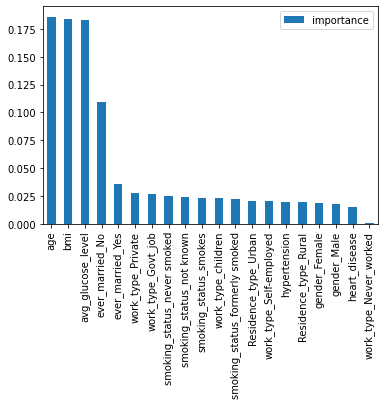

In [137]:
# Feature Importance
fi2=pd.DataFrame(fip, index=X_train.columns,columns=['importance']).sort_values('importance',
                                                                        ascending=False)
fi2.plot(kind='bar')

# MODEL EVALUATION
- Performance of the models are plotted using bar plot and arranged in the descending order of performance.
  - Gradient Boosting is the most accurate model producing 98% accuracy which is great.
  - Ensemble learning algorithms such as Gradient Boosting and Random forest performed exceptionally well in predicting the stroke followed by Neural network


In [174]:
# Model Evaluation
model_evaluation(XGB,RFC,NN,KNNS,DTC,LR)
